<a href="https://colab.research.google.com/github/sameershinde14/ToxicCommentsChallengeKaggle/blob/master/LSTN_Toxic_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
path = './sample_data/'
comp = './pickle/'
EMBEDDING_FILE=f'glove.6B.50d.txt'
TRAIN_DATA_FILE=f'train.csv'
TEST_DATA_FILE=f'test.csv'

In [0]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [0]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [8]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0.020940498, 0.6441043)

In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
import tensorflow as tf
from keras import backend as K
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [11]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [12]:
history = model.fit(X_t, y, batch_size=32, epochs=10, validation_split=0.1);

Instructions for updating:
Use tf.cast instead.
Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 669s 5ms/step - loss: 0.0598 - auc: 0.9356 - val_loss: 0.0484 - val_auc: 0.9713
Epoch 2/10
143613/143613 [==============================] - 669s 5ms/step - loss: 0.0444 - auc: 0.9760 - val_loss: 0.0452 - val_auc: 0.9786
Epoch 3/10
143613/143613 [==============================] - 656s 5ms/step - loss: 0.0401 - auc: 0.9806 - val_loss: 0.0449 - val_auc: 0.9819
Epoch 4/10
143613/143613 [==============================] - 679s 5ms/step - loss: 0.0370 - auc: 0.9831 - val_loss: 0.0457 - val_auc: 0.9839
Epoch 5/10
143613/143613 [==============================] - 664s 5ms/step - loss: 0.0342 - auc: 0.9847 - val_loss: 0.0473 - val_auc: 0.9853
Epoch 6/10
143613/143613 [==============================] - 671s 5ms/step - loss: 0.0318 - auc: 0.9859 - val_loss: 0.0539 - val_auc: 0.9863
Epoch 7/10
143613/143613 [==============================] - 6

In [13]:
from matplotlib import pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_auc', 'loss', 'auc'])


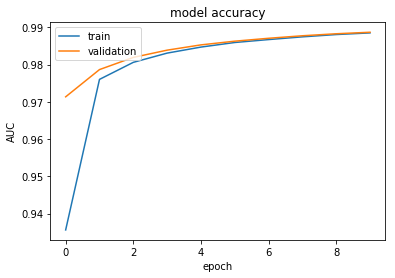

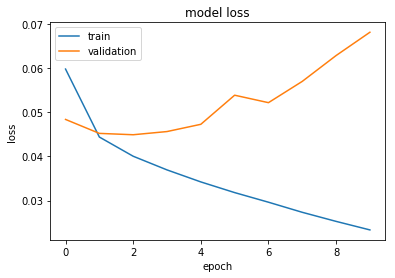

In [18]:
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)

153164/153164 [==============================] - 88s 572us/step
